In [13]:
# text-preprocessing
from matplotlib import pyplot as plt
import torch,random,re,collections

In [14]:
# 读取数据集
with open("./data/timemachine.txt", "r") as f:
    lines = f.readlines()
lines = [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]


# 词元化
def tokenize(strings, token="word"):
    if token == "word":
        return [str.split() for str in strings]
    elif token == "char":
        return [list(str) for str in strings]
    else:
        print("Wrong!")


tokens = tokenize(lines, token="word")
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [15]:
# 统计词元的频率
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


# 词表
class Vocabulary:
    def __init__(self, tokens=None, min_freq=0, reversed_tokens=None) -> None:
        if tokens == None:
            tokens = []
        if reversed_tokens == None:
            reversed_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=self.cmp, reverse=True)
        self.idx_to_token = ["<unk>"] + reversed_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break  # 后面的不加入到词表中
            if token not in self.token_to_idx:
                self.token_to_idx[token] = len(self.idx_to_token)
                self.idx_to_token.append(token)

    def cmp(self, x):
        return x[1]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.to_tokens(indice) for indice in indices]

In [16]:
vocab = Vocabulary(tokens)
print(list(vocab.token_to_idx.items())[:10])
print(vocab['ads'])
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
0
文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [17]:
def load_cropus(max_tokens=-1, file_name="timemachine", pattern="char"):

    with open(f"./data/{file_name}.txt", "r") as f:
        lines = f.readlines()
    lines = [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]
    tokens = tokenize(lines, pattern)
    vocab = Vocabulary(tokens=tokens, min_freq=0)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [18]:
corpus, vocab = load_cropus(pattern='word')
len(corpus), len(vocab)

(32775, 4580)

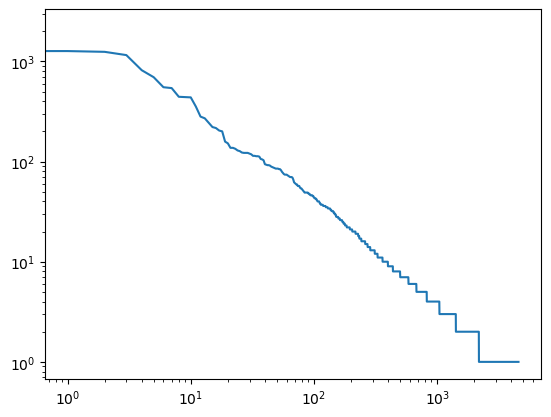

In [19]:
freqs=[freq for token,freq in vocab.token_freqs]
plt.plot([i for i in range(len(freqs))],freqs)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [20]:
def seq_data_iter_random(corpus, batch_size, num_steps, random_offset="True"):
    if random_offset:
        a = random.randint(0, num_steps - 1)
        # 如果偏移量大于时间步x，则偏移量中的x可以作为新的时间步
    else:
        a = 0
    print(f'random offset: {a}')
    # update corpus
    corpus = corpus[a:]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices=[i*num_steps for i in range(num_subseqs)]
    random.shuffle(initial_indices)
    num_batches=num_subseqs//batch_size
    for i in range(0,num_batches*batch_size,batch_size):
        initial_indices_per_batch=initial_indices[i:i+batch_size]
        X=[corpus[j:j+num_steps]for j in initial_indices_per_batch]
        Y=[corpus[j+1:j+num_steps+1]for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(Y)


In [21]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

random offset: 2
X:  tensor([[22, 23, 24, 25, 26],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]])
X:  tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [ 3,  4,  5,  6,  7]])


In [22]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  # @save
    offset = random.randint(0, num_steps - 1)
    offset = 0
    corpus = corpus[offset:]
    num_tokens = ((len(corpus) - 1 )// batch_size) * batch_size
    Xs = torch.tensor(corpus[0:num_tokens]).reshape(batch_size, -1)
    Ys = torch.tensor(corpus[1 : num_tokens + 1]).reshape(batch_size, -1)
    num_batches = num_tokens // (batch_size * num_steps)
    for i in range(0, num_batches):
        X = Xs[:, i * num_steps : (i + 1) * num_steps]
        Y = Ys[:, i * num_steps : (i + 1) * num_steps]
        yield X, Y


for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print("X: ", X, "\nY:", Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [23]:
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens) -> None:
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_cropus(max_tokens, pattern="word")
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [24]:
def load_data_time_machine(batch_size, num_steps, 
    use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter=use_random_iter, max_tokens=max_tokens
    )
    return data_iter, data_iter.vocab